# 1. Getting familiar with optimization test problems


In this laboratory session, we will explore two popular extensions of basic Gradient Descent:

- Momentum-based Gradient Descent
- Adam (Adaptive Moment Estimation)

We will test these methods on three classical benchmark functions in 2D space:

- Sphere: a simple, convex, unimodal function that is relatively easy to optimize.
- Rosenbrock: features a narrow valley, making convergence more difficult.
- Rastrigin: contains many local minima, making it challenging to escape suboptimal points.


In [1]:
from abc import ABC, abstractmethod

import numpy as np


class Problem(ABC):
    @abstractmethod
    def __call__(self, x: np.ndarray) -> float:
        """Compute the function value at point x."""
        raise NotImplementedError

    @abstractmethod
    def grad(self, x: np.ndarray) -> np.ndarray:
        """Compute the gradient at point x."""
        raise NotImplementedError


class Sphere(Problem):
    def __call__(self, x: np.ndarray) -> float:
        return np.sum(x**2)

    def grad(self, x: np.ndarray) -> np.ndarray:
        return 2 * x


class Rosenbrock(Problem):
    def __call__(self, x: np.ndarray) -> float:
        return np.sum(100.0 * (x[1:] - x[:-1] ** 2) ** 2 + (1 - x[:-1]) ** 2)

    def grad(self, x: np.ndarray) -> np.ndarray:
        grad = np.zeros_like(x)
        n = x.size
        grad[0] = -400 * x[0] * (x[1] - x[0] ** 2) - 2 * (1 - x[0])
        for i in range(1, n - 1):
            grad[i] = (
                200 * (x[i] - x[i - 1] ** 2)
                - 400 * x[i] * (x[i + 1] - x[i] ** 2)
                - 2 * (1 - x[i])
            )
        grad[-1] = 200 * (x[-1] - x[-2] ** 2)
        return grad


class Rastrigin(Problem):
    def __call__(self, x: np.ndarray) -> float:
        A = 10
        n = x.size
        return A * n + np.sum(x**2 - A * np.cos(2 * np.pi * x))

    def grad(self, x: np.ndarray) -> np.ndarray:
        A = 10
        return 2 * x + 2 * np.pi * A * np.sin(2 * np.pi * x)


In [2]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go


def prepare_mesh_grid(
    problem: Problem,
    bounds: tuple[float, float] = (-5.0, 5.0),
    grid_size: int = 50,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    x_vals = np.linspace(bounds[0], bounds[1], grid_size)
    y_vals = np.linspace(bounds[0], bounds[1], grid_size)
    X, Y = np.meshgrid(x_vals, y_vals)

    Z = np.zeros_like(X)
    for i in range(grid_size):
        for j in range(grid_size):
            xy = np.array([X[i, j], Y[i, j]])
            Z[i, j] = problem(xy)

    return X, Y, Z, x_vals, y_vals


def plot_3d_surface(
    problem: Problem,
    grid_size: int = 50,
):
    X, Y, Z, _, _ = prepare_mesh_grid(problem=problem, grid_size=grid_size)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor="none")

    ax.set_title(problem.__class__.__name__)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("f(x, y)")

    fig.colorbar(surf, shrink=0.5, aspect=10)
    plt.tight_layout()
    plt.show()


def plot_contour_and_paths(
    problem: Problem,
    paths: list[np.ndarray],
    grid_size: int = 200,
    title: str = "",
):
    """
    Create an interactive contour plot of a 2D function and overlay multiple optimization paths.

    Args:
        problem: An instance of a Problem class.
        paths: List of numpy arrays; each array is of shape (epochs, 2) containing an optimization trajectory.
        title: Title for the plot.
    """
    _, _, Z, x_vals, y_vals = prepare_mesh_grid(problem, grid_size=grid_size)
    colors = [
        "#636EFA",
        "#EF553B",
        "#00CC96",
        "#AB63FA",
        "#FFA15A",
        "#19D3F3",
        "#FF6692",
        "#B6E880",
        "#FF97FF",
        "#FECB52",
    ]
    fig = go.Figure(
        data=go.Contour(
            x=x_vals,
            y=y_vals,
            z=Z,
            colorscale="Viridis",
            contours=dict(showlines=False),
            colorbar=dict(title="Function Value"),
        )
    )

    for idx, path in enumerate(paths):
        fig.add_trace(
            go.Scatter(
                x=path[:, 0],
                y=path[:, 1],
                mode="lines+markers",
                marker=dict(size=4),
                line=dict(width=2, color=colors[idx]),
                name=f"Run {idx + 1}",
                showlegend=True,
            )
        )

    fig.update_layout(
        title=title,
        xaxis_title="x",
        yaxis_title="y",
        width=800,
        height=700,
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    )

    fig.show()

## Understand the landscapes of the test functions to predict optimization challenges


We will use plot_3d_surface to generate a 3D surface plot for each function (Sphere, Rosenbrock, Rastrigin). <br>
We will use plot_contour_and_paths with an empty paths list to generate a 2D contour plot for each function.


Function being easiest to optimize surely is the Sphere, because there's only one minimum, available to be reached from every point in the sphere


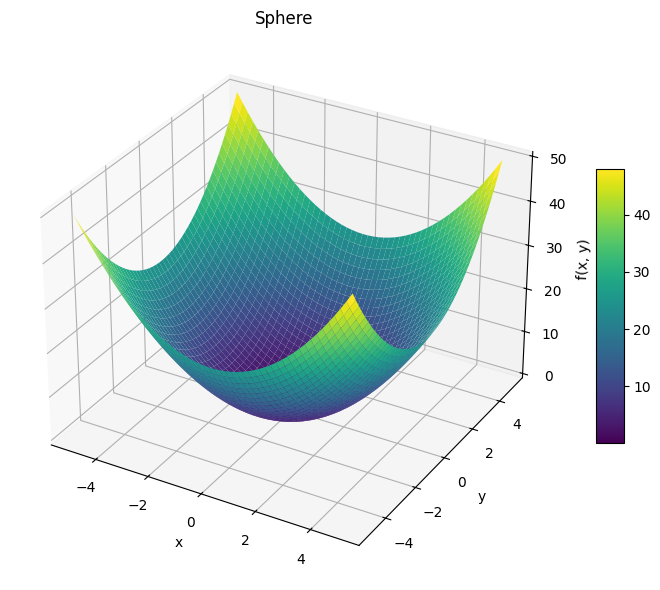

In [3]:
plot_3d_surface(Sphere())

In [4]:
plot_contour_and_paths(Sphere(), paths=[])

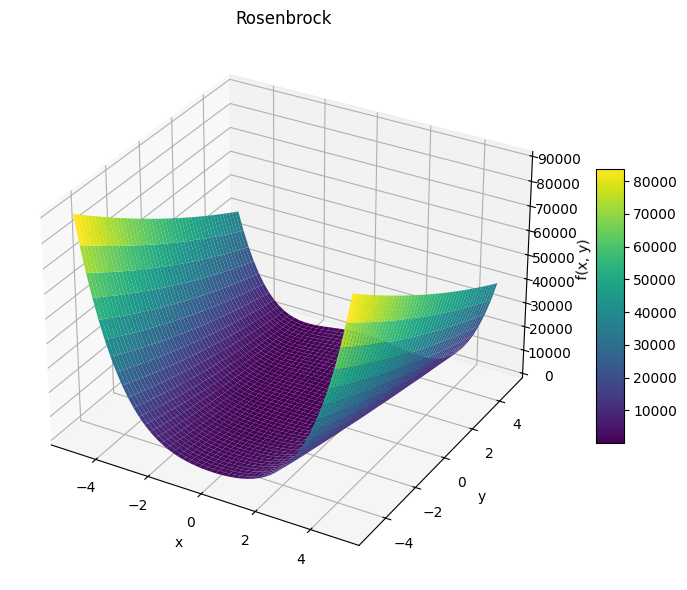

In [5]:
plot_3d_surface(Rosenbrock())

In [6]:
plot_contour_and_paths(Rosenbrock(), [])

Function being hardest to optimize surely is the Rastrigin, because there's no clear global minimum and there's plenty of local minimums, making it hard, if even possible, to find the optimum point


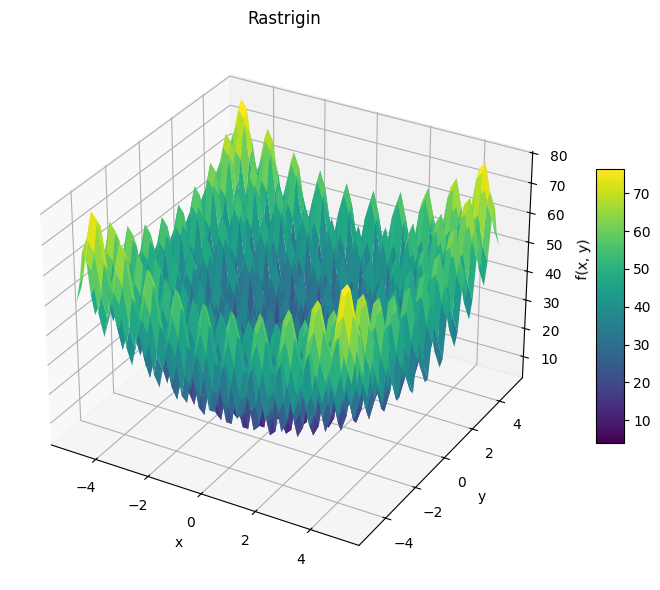

In [7]:
plot_3d_surface(Rastrigin())

In [8]:
plot_contour_and_paths(Rastrigin(), [])

# 2. Momentum method


We implement Momentum optimizer, where: <br>

- initial_solution is the starting point.
- alpha is the learning rate.
- beta is the momentum parameter (commonly 0.9).


In [9]:
def momentum(
    problem: Problem,
    initial_solution: np.ndarray = np.array([2.0, 2.0]),
    alpha: float = 0.01,
    beta: float = 0.9,
    number_of_epochs: int = 1000,
):
    X = initial_solution.copy()
    v = np.zeros_like(X)
    X_history = [X.copy()]
    v_history = []

    for i in range(number_of_epochs):
        v = beta * v - alpha * problem.grad(X)
        X += v
        v_history.append(np.linalg.norm(v))
        X_history.append(X.copy())

    return X, v, np.array(X_history), v_history


# 3. Experiments with Momentum


We will observe how Momentum performs on different functions.
<br><br>
We'll use following parameters:

- initial_solution = np.array([2.0, 2.0]),
- alpha = 0.01,
- beta = 0.9,
- number_of_epochs = 100.

For each function, plot:

- Function value vs. epoch.
- Velocity norm (e.g np.linalg.norm) vs. epoch.


We can see that the Velocity Norm:

- Is drifting towards 0 as function value drifts towards its minimum value
- Correlates with convergence speed

Except for the Rastrigin problem, where the optimized seems to not be able to converge and find an optimal value


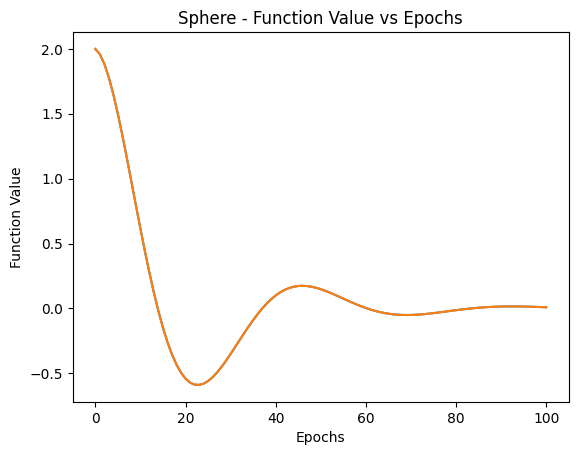

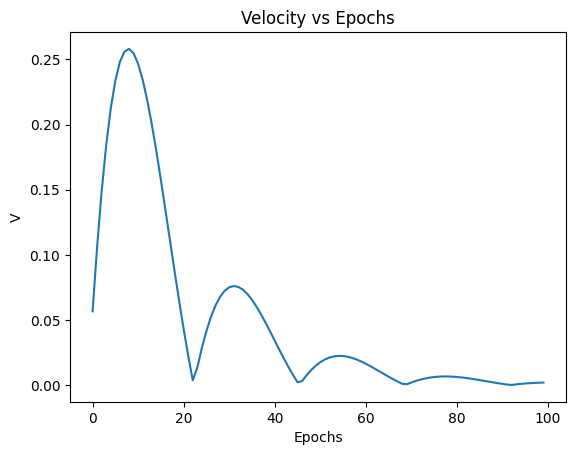

In [10]:
X, v, x_history, v_history = momentum(
    Sphere(), np.array([2.0, 2.0]), 0.01, number_of_epochs=100
)

plt.plot(x_history)
plt.xlabel("Epochs")
plt.ylabel("Function Value")
plt.title("Sphere - Function Value vs Epochs")
plt.show()

plt.plot(v_history)
plt.xlabel("Epochs")
plt.ylabel("V")
plt.title("Velocity vs Epochs")
plt.show()

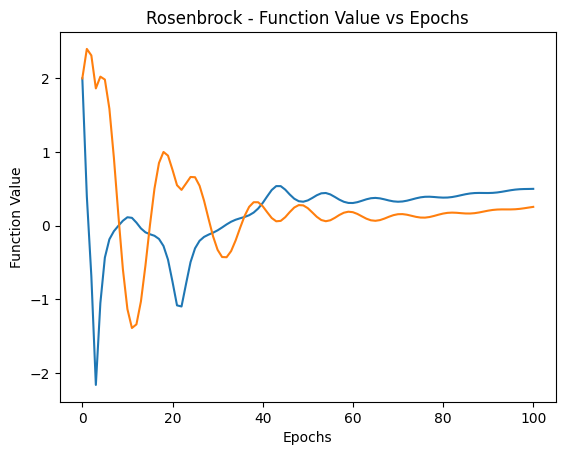

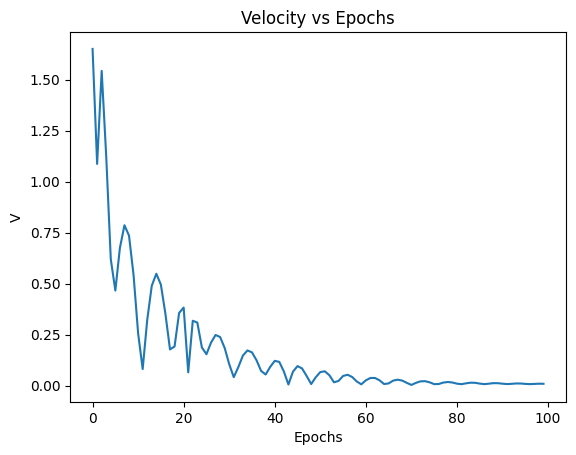

In [11]:
X, v, x_history, v_history = momentum(
    Rosenbrock(), np.array([2.0, 2.0]), alpha=0.001, beta=0.9, number_of_epochs=100
)

plt.plot(x_history)
plt.xlabel("Epochs")
plt.ylabel("Function Value")
plt.title("Rosenbrock - Function Value vs Epochs")
plt.show()

plt.plot(v_history)
plt.xlabel("Epochs")
plt.ylabel("V")
plt.title("Velocity vs Epochs")
plt.show()

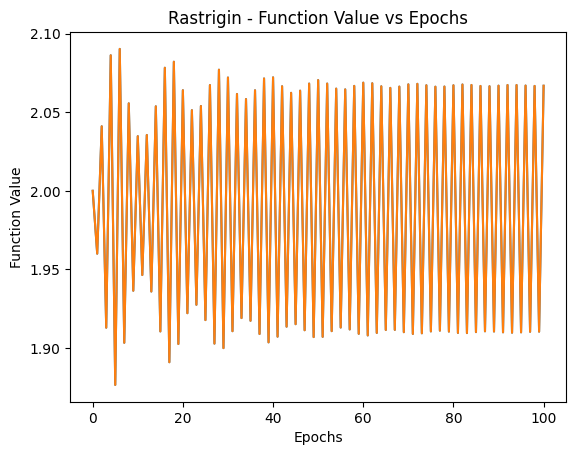

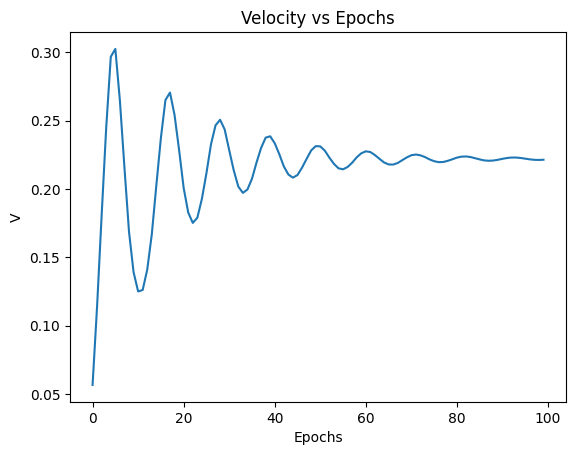

In [12]:
X, v, x_history, v_history = momentum(
    Rastrigin(), np.array([2.0, 2.0]), alpha=0.01, beta=0.9, number_of_epochs=100
)

plt.plot(x_history)
plt.xlabel("Epochs")
plt.ylabel("Function Value")
plt.title("Rastrigin - Function Value vs Epochs")
plt.show()

plt.plot(v_history)
plt.xlabel("Epochs")
plt.ylabel("V")
plt.title("Velocity vs Epochs")
plt.show()

# 4. Momentum Hyperparameters


Fix alpha = 1e-5, initial_solution = np.array([2.0, 2.0]), number_of_epochs = 100. Use β ∈ [ 0.5 , 0.75 , 0.9 , 0.95 , 0.99 ] on the Rosenbrock function.


Generally, I can say that increasing β increases stability and the speed of convergence but up to a certain point. The best results are seen at β = 0.9. <br>
For higher alpha of 1e-4, the numbers would overflow for β of 0.95 and 0.99, also the function value and velocity starts to diverge. On the other hand, for β of 0.5 or 0.75 the optimizer doesn't seem to be able to converge and the two graphs are very divergent


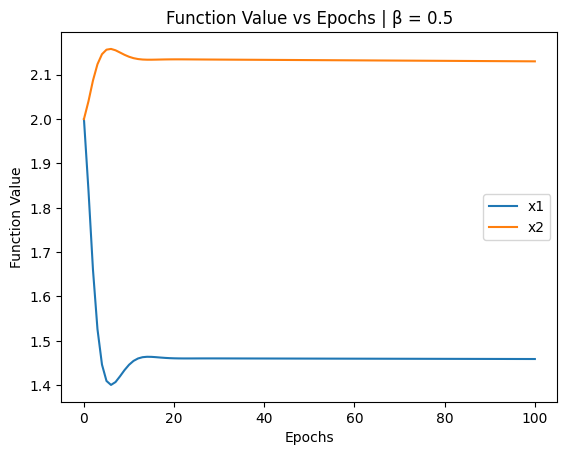

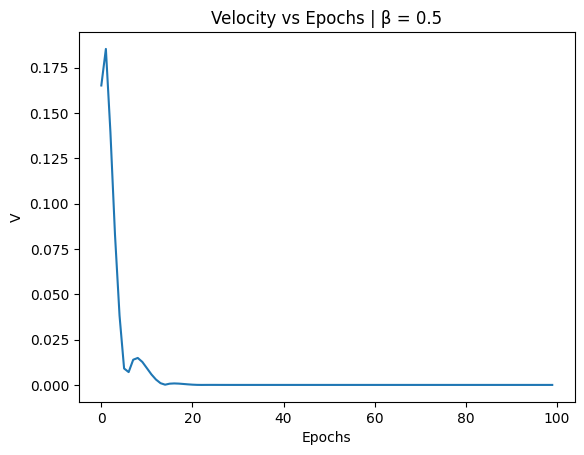

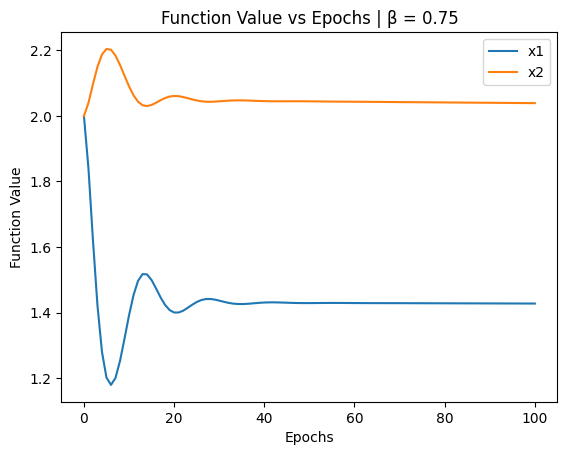

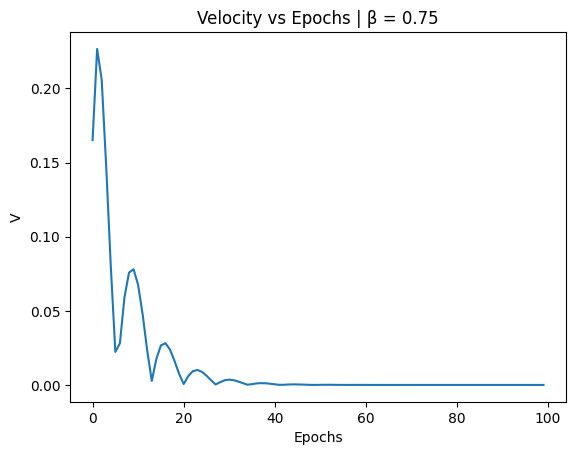

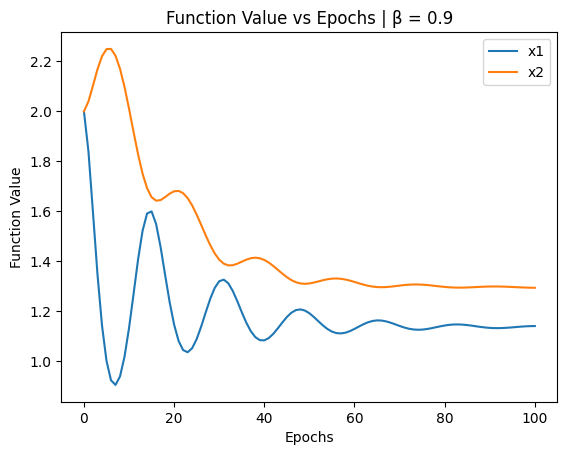

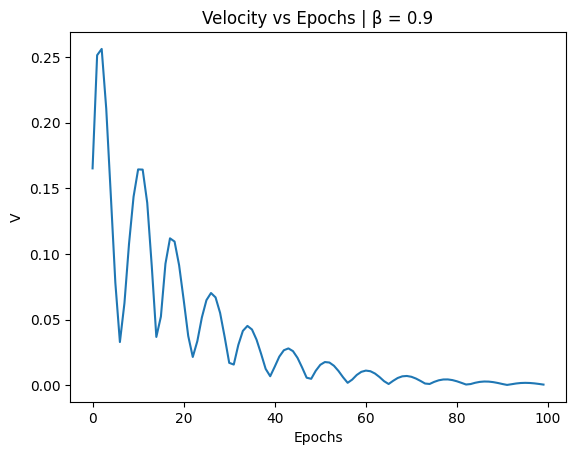

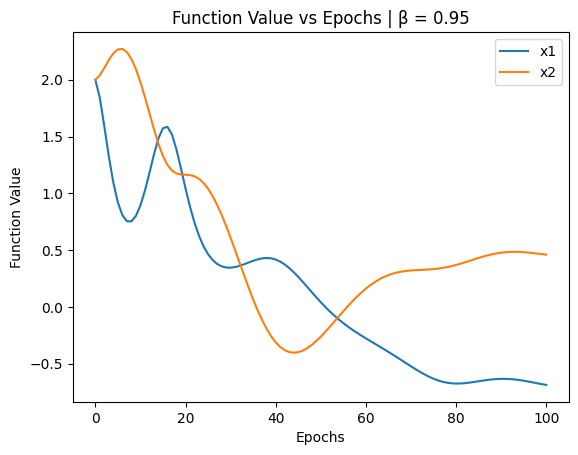

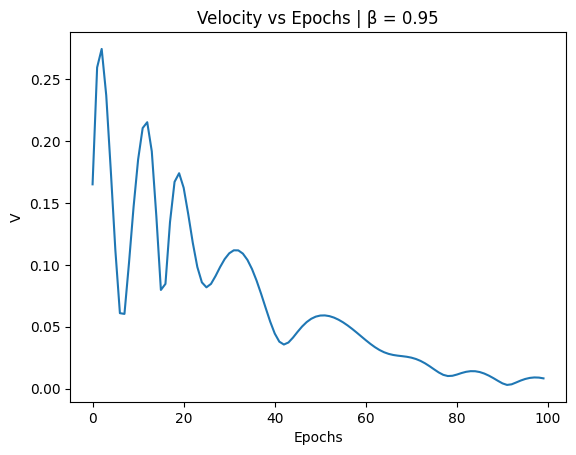

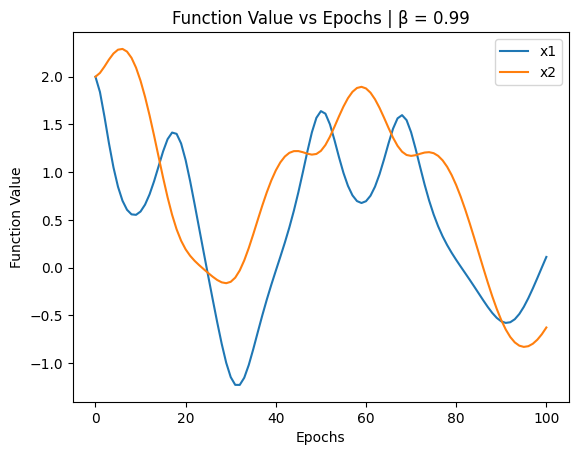

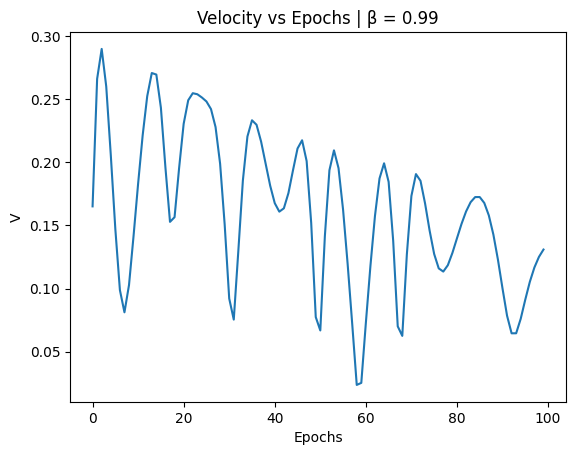

In [13]:
for b in [0.5, 0.75, 0.9, 0.95, 0.99]:
    X, v, x_history, v_history = momentum(
        Rosenbrock(),
        alpha=10e-5,
        beta=b,
        initial_solution=np.array([2.0, 2.0]),
        number_of_epochs=100,
    )
    plt.plot([x[0] for x in x_history], label="x1")
    plt.plot([x[1] for x in x_history], label="x2")
    plt.xlabel("Epochs")
    plt.ylabel("Function Value")
    plt.title(f"Function Value vs Epochs | β = {b}")
    plt.legend()
    plt.show()

    plt.plot(v_history)
    plt.xlabel("Epochs")
    plt.ylabel("V")
    plt.title(f"Velocity vs Epochs | β = {b}")
    plt.show()

# 5. Adam


We implement the Adam optimizer, where:

- beta1 is the exponential decay rate for first moment estimates (similar to momentum).
- beta2 is the exponential decay rate for second moment estimates (variance).


In [14]:
def adam(
    problem: Problem,
    initial_solution: np.ndarray = np.array([2.0, 2.0]),
    alpha: float = 0.01,
    beta1: float = 0.9,
    beta2: float = 0.999,
    number_of_epochs: int = 100,
    epsilon: float = 1e-8,
):
    X = initial_solution.copy()
    v = np.zeros_like(X)
    m = np.zeros_like(X)
    X_history = [X.copy()]

    for i in range(1, number_of_epochs + 1):
        grad = problem.grad(X)
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * grad**2
        bias_m = m / (1 - beta1**i)
        bias_v = v / (1 - beta2**i)
        X -= (alpha * bias_m) / (np.sqrt(bias_v) + epsilon)
        X_history.append(X.copy())

    return np.array(X_history)

# 6. Comparing Adam with Momentum


We'll run both optimizers on Sphere, Rosenbrock and Rastrigin with:

- initial_solution = np.array([2.0, 2.0]),
- number_of_epochs = 100.

Momentum:

- alpha = 0.01 (0.001 for Rosenbrock, otherwise would overflow),
- beta = 0.9.

Adam:

- alpha = 0.01,
- beta1 = 0.9,
- beta2 = 0.999,
- epsilon = 1e-8.

We will:

- visualize optimization paths,
- use plot_contour_and_paths to overlay paths from both methods,
- plot function value vs. epoch for both methods.


Compared to Adam, Momentum seems very chaotic and unstable. Adam optimizer looks as far more balanced and sophisticated method


In [15]:
X, v, momentum_X_history, momentum_v_history = momentum(
    Sphere(),
    alpha=0.01,
    beta=0.9,
    initial_solution=np.array([2.0, 2.0]),
    number_of_epochs=100,
)

adam_X_history = adam(Sphere())

plot_contour_and_paths(Sphere(), [momentum_X_history, adam_X_history])

In [16]:
X, v, momentum_X_history, momentum_v_history = momentum(
    Rosenbrock(),
    alpha=0.001,
    beta=0.9,
    initial_solution=np.array([2.0, 2.0]),
    number_of_epochs=100,
)

adam_X_history = adam(Rosenbrock())

plot_contour_and_paths(Rosenbrock(), [momentum_X_history, adam_X_history])

In [17]:
X, v, momentum_X_history, momentum_v_history = momentum(
    Rastrigin(),
    alpha=0.01,
    beta=0.9,
    initial_solution=np.array([2.0, 2.0]),
    number_of_epochs=100,
)

adam_X_history = adam(Rastrigin())

plot_contour_and_paths(Rastrigin(), [momentum_X_history, adam_X_history])

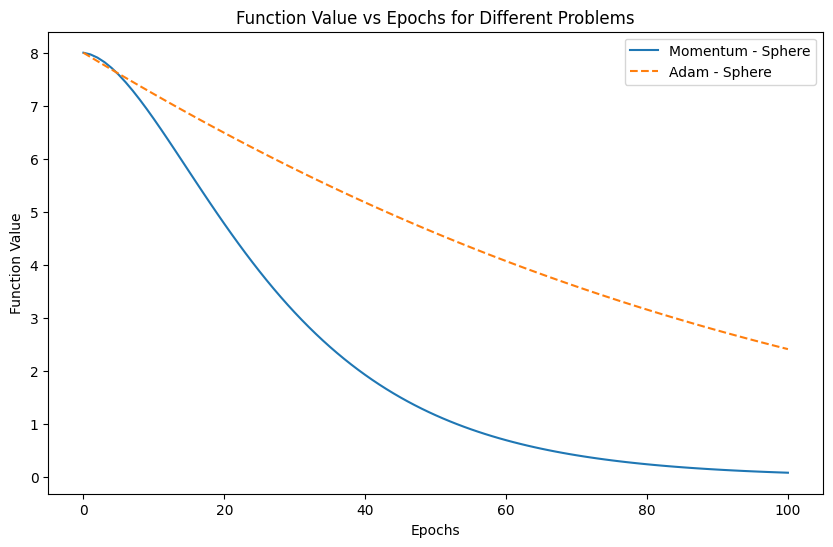

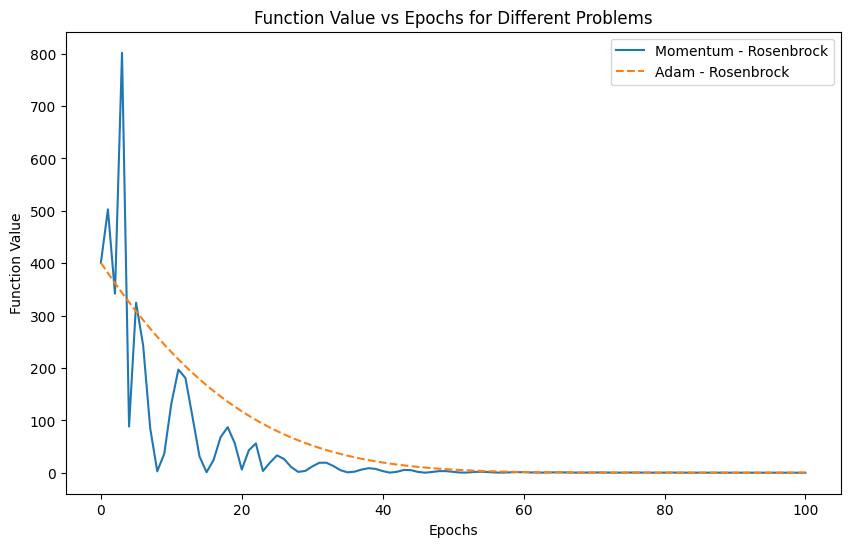

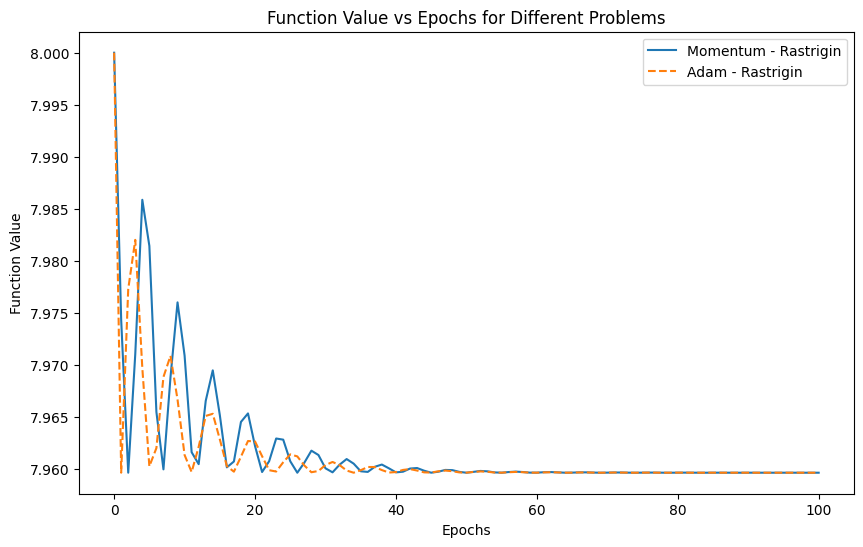

In [ ]:
problems = [Sphere(), Rosenbrock(), Rastrigin()]
problem_names = ["Sphere", "Rosenbrock", "Rastrigin"]

for problem, name in zip(problems, problem_names):
    _, _, momentum_x_history, _ = momentum(
        problem, np.array([2.0, 2.0]), alpha=0.001, beta=0.9, number_of_epochs=100
    )

    adam_x_history = adam(problem, number_of_epochs=100)

    momentum_values = [problem(x) for x in momentum_x_history]
    adam_values = [problem(x) for x in adam_x_history]

    plt.figure(figsize=(10, 6))
    plt.plot(momentum_values, label=f"Momentum - {name}")
    plt.plot(adam_values, linestyle="dashed", label=f"Adam - {name}")

    plt.xlabel("Epochs")
    plt.ylabel("Function Value")
    plt.title("Function Value vs Epochs for Different Problems")
    plt.legend()
    plt.show()
